In [1]:
import os
import json
import math
import gradio as gr
import pandas as pd
import numpy as np
from tqdm import tqdm
import spotipy
import sqlite3
from sklearn.cluster import KMeans
from sqlite3 import Error
import seaborn as sns
import matplotlib.pyplot as plt
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
import spotipy.util as util
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from openTSNE import TSNE as openTSNE
from wordcloud import WordCloud
from wordcloud import STOPWORDS as STOPWORDS

In [2]:
def connect_db(db_file):
    conn = None
    try:
        conn = sqlite3.connect(db_file)
    except Error as e:
        print(e)
    return conn

In [3]:
def connect_to_spotify():
    # Spotify credentials
    cid = "5cffc2676cd44b35bc6af81faeb8e69a"
    secret = "f9fdae88362349b992ab2714ea91a094"
    os.environ["SPOTIPY_CLIENT_ID"] = cid
    os.environ["SPOTIPY_CLIENT_SECRET"] = secret
    os.environ['SPOTIPY_REDIRECT_URI'] = "http://127.0.0.1:8080/callback"
    client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
    sp = spotipy.Spotify(client_credentials_manager = SpotifyClientCredentials())

    return sp

In [4]:
def create_playlist(tracks, input_words, username="anikahamby"):
    #must give a list of track ids, must include "spotify:track:"
    #user_id = "1a0f1b9085db4f49"
    #username = "31y7j5k3jeidd5rzhaznsdregg34"
    user_id = "99aec62618cf4106"
    #username = "anikahamby"
    playlistName = ""
    scope = "playlist-modify-public"
    songs_to_add = []
    for word in input_words:
        playlistName += word + " "
        
    for i in range(len(tracks)):
        songs_to_add.append("spotify:track:" + tracks[i])

    token = SpotifyOAuth(scope = scope, username = username)
    if token:
        sp = spotipy.Spotify(auth_manager=token)
        sp.user_playlist_create(user = username, name = playlistName)
        prep = sp.user_playlists(user = username)
        playlist = prep['items'][0]['id']
        sp.user_playlist_add_tracks(user = username, playlist_id= playlist, tracks=songs_to_add)
        print("Playlist created")
    else:
        print("Can't get token for", username)

    


In [30]:
def get_sample_data(input_words, cur):
    sql_select = '''SELECT * FROM avg_features_by_playlist WHERE'''
    for w in range(len(input_words)):
        sql_select += " name LIKE '%" + input_words[w] + "%'"
        if w != len(input_words) -1:
            sql_select += " OR" 
    sql_select += " LIMIT 100"
    pl_train = cur.execute(sql_select).fetchall()
    return pl_train

In [6]:
def scale_data(x_data, y_data, feature_columns):
    y = y_data[feature_columns].mean()

    scaler = StandardScaler(with_mean=True, with_std=True).fit(x_data[feature_columns].values)

    scaled_x = scaler.transform(x_data[feature_columns].values)
    scaled_y = scaler.transform(np.array(y).reshape(1,-1))
    tsne = openTSNE(perplexity=30, metric='euclidean', n_jobs=-1, random_state=0, verbose=False)
    tsne_transformer = tsne.fit(scaled_x)
    data_df = pd.DataFrame(tsne_transformer.transform(scaled_x), columns =['X', 'Y'])

    return data_df, scaled_x, scaled_y

In [7]:
def show_clusters(data, title):
    sns.scatterplot(x='X', y='Y', hue='cluster', style='cluster', data=data, legend=None)
    plt.title(title)
    plt.show()

In [8]:
def wordclouds(data, n_clusters):
    # we want to perform a pivot on data_df so that each cluster number is a column with row value equal to the playlist name.
    # from there we can sum up that column to get the whole lsit of strings of playlist names for each cluster (column)
    original_df = data.pivot(columns='cluster')['playlist_name'].reset_index()
    original_df.columns.name = None
    original_df = original_df.fillna('')

    #list of words to ignore
    stop_words = STOPWORDS.update(["i", "it", "me", "my", "that", "the", "of", "than", "then", 
    "when", "if", "a", "there", "playlist", "mix", "new", "good", "music", "song", "songs", "to", "too", "get", "as", "this", 
    "am", "is", "are", "has", "and", "aa", "aaa", 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'j', 'k', 'l', 'm', 'n', 
    'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])

    wordclouds = {}
    for i in range(n_clusters):
        original_df.replace(np.nan, '')
        original_df[i] = original_df[i].astype(str) #.sum(skipna=True))
        wordclouds["wordcloud" + str(i)] = WordCloud(stopwords=stop_words).generate(' '.join(original_df[i]))

    index = 0
    for val in wordclouds.values():
        print("Cluster number ", index)
        plt.imshow(val)
        plt.axis("off")
        plt.show()
        index += 1

In [9]:
def get_target_cluster_songs(data, target_cluster):
    original_df = data.pivot(columns='cluster', values='pid')
    target_cluster_df = original_df[[target_cluster]].dropna()
    conn = connect_db('data.db')
    cur = conn.cursor()
    sql = '''SELECT features_by_track.* FROM features_by_track join tracks_in_playlist on features_by_track.track_uri = tracks_in_playlist.track_uri
        WHERE '''
    for pid in target_cluster_df[target_cluster].values:
        sql += "tracks_in_playlist.pid = " + str(int(pid))
        sql += " OR "
    sql = sql[:-3]
    cols = ["track_uri",
        "danceability",
        "energy",
        "key",
        "loudness",
        "mode",
        "speechiness",
        "acousticness",
        "instrumentalness",
        "liveness",
        "valence",
        "tempo",
        "duration_ms",
        "time_signature"]
        
    result = cur.execute(sql).fetchall()
    
    conn.close()
    tracks = pd.DataFrame(result, columns = cols)
    tracks = tracks[tracks['track_uri'].map(tracks['track_uri'].value_counts()) > 3]

    track_counts = pd.DataFrame()
    track_counts['counts'] = tracks.groupby(['track_uri'])['time_signature'].transform('count')
    tracks = tracks.drop_duplicates(subset=['track_uri'])
    #song_instances = tracks['counts'].sum()

    num_unique_songs = len(pd.unique(tracks['track_uri']))
    return tracks

In [10]:
def secondary_get_target_cluster_songs(data, target_cluster_songs, target_cluster):
    #data["track_uri"] = target_cluster_songs['track_uri']
    original_df = data.pivot(columns='cluster', values='track_uri')
    target_cluster_df = original_df[[target_cluster]].dropna()
    target_cluster_df = target_cluster_df.drop_duplicates(subset=[target_cluster])
    
    conn = connect_db('data.db')
    cur = conn.cursor()
    sql = "SELECT track_name, track_uri FROM tracks WHERE "
    for uri in target_cluster_df[target_cluster].values:
        sql += "track_uri = " + "\"" + uri + "\""
        sql += " OR "
    sql = sql[:-3]
    cols = ["track_name", "track_uri"]
    
    result = cur.execute(sql).fetchall()
    conn.close()

    tracks = pd.DataFrame(result, columns = cols)
    tracks = tracks.drop_duplicates(subset=["track_uri"])
    return tracks

In [11]:
def generate_playlist(song_df, center_x, center_y, ids):
    song_df = song_df.drop_duplicates(subset=["track_uri"])
    # drop URI, for whatever reason it's empty and useless for this
    song_df = song_df.drop(columns='track_uri')
    
    # x2 - x1
    x_vals = song_df['X'].apply(lambda x: x - center_x)
    
    # y2 - y1
    y_vals = song_df['Y'].apply(lambda x: x - center_y)
    
    # square both
    x_vals = np.power(x_vals, 2)
    y_vals = np.power(y_vals, 2)

    # final distances between the center and all of the points
    distances = np.sqrt(x_vals + y_vals)
    
    
    # now append the song ids column!
    distances =  pd.DataFrame(distances)
    distances['id'] = ids
    
    # sort by distance and return the whole thing
    sorted_distances = distances.sort_values(by=0)
    closest_song_ids = sorted_distances
    return closest_song_ids

In [29]:
def prepare_data(input_words):
    # connect to database
    conn = connect_db('data.db')
    cur = conn.cursor()
    
    # Get sample for predicting
    test_cols = ['pid', 'name', 'danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','duration_ms','time_signature']
    testing_sample = get_sample_data(input_words, cur)
    test_data = pd.DataFrame(testing_sample, columns=test_cols)

    # Get X data (average playlist features)
    data_cols = ['pid', 'name', 'danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','duration_ms','time_signature']
    feature_cols = ['danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','duration_ms','time_signature']
    data_rows = cur.execute('select * from avg_features_by_playlist where pid > (select MIN(pid) from avg_features_by_playlist) order by pid limit 1500').fetchall()
    data = pd.DataFrame(data_rows, columns=data_cols)

    training_data, X, Y = scale_data(data, test_data, feature_cols)

    conn.close()
    
    return training_data, test_data, feature_cols, X, Y, data

In [13]:
def demo_output(track_ids):
    # output songs as a dataframe
    sql = "SELECT track_name FROM tracks WHERE track_uri IN ("
    for uri in track_ids:
        sql += "'" + uri + "', "
    sql = sql[:-2] + ")"
    
    conn = connect_db('data.db')
    cur = conn.cursor()

    track_names = cur.execute(sql).fetchall()

    conn.close()

    track_names_df = pd.DataFrame(track_names, columns=["Track Name"])
    return track_names

In [14]:
def pipeline(data_is_loaded, training_data=None, test_data=None, feature_cols=None, X=None, Y=None, input_words=None, data=None, username=None, demo=False):
    if not data_is_loaded:
        training_data, test_data, feature_cols, X, Y, data= prepare_data(input_words)

    # Cluster and predict cluster
    n_clusters = 20
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    clusters = kmeans.fit(X)
    labels = clusters.labels_
    training_data['cluster'] = pd.Categorical(labels)
    target_cluster = kmeans.predict(Y)

    if not demo:
        print("Chosen cluster:", target_cluster[0])

    if not demo:
        show_clusters(training_data, "Playlist Clustering")

    # add playlist names to training data
    training_data["playlist_name"] = data['name'].str.lower()

    # display word clouds    
    if not demo:
        wordclouds(training_data, n_clusters)


    # Get tracks from cluster
    training_data['pid'] = data['pid']
    tracks_in_cluster = get_target_cluster_songs(training_data, target_cluster[0])

    # Scale track data
    song_training_data, X, Y = scale_data(tracks_in_cluster, test_data, feature_cols)

    # Do secondary clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit(X)
    labels = clusters.labels_
    song_training_data['cluster'] = pd.Categorical(labels)
    song_target_cluster = kmeans.predict(Y)

    if not demo:
        show_clusters(training_data, "Song Clustering")
    
    song_training_data['track_uri'] = tracks_in_cluster['track_uri']
    
    # Get songs from secondary cluster
    target_songs = secondary_get_target_cluster_songs(song_training_data, tracks_in_cluster, song_target_cluster[0])

    song_data = pd.merge(song_training_data, target_songs, on=['track_uri'], how='inner')
    # Get songs closest to cluster center 
    results = target_songs['track_uri']
    results = results.values.tolist()
    centers = clusters.cluster_centers_[song_target_cluster]
    results = generate_playlist(song_data.loc[song_data['cluster'] == song_target_cluster[0]], centers[:, 0][0], centers[:, 1][0], results)['id'].tolist()

    # Create the playlist and add it to spotify
    if username:
        create_playlist(results, input_words, username)
    
   


In [15]:
# run once
sp = connect_to_spotify()

In [31]:
training_data, test_data, feature_cols, X, Y, data = prepare_data(['chill', 'beach', 'party'])

Chosen cluster: 15


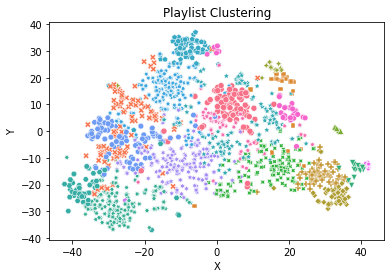

Cluster number  0


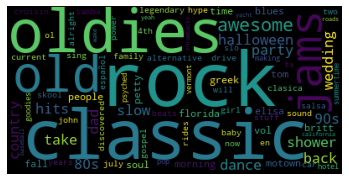

Cluster number  1


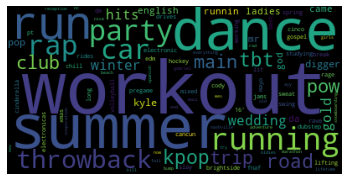

Cluster number  2


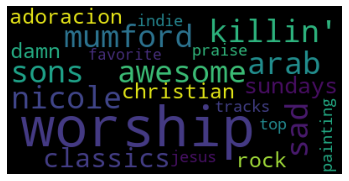

Cluster number  3


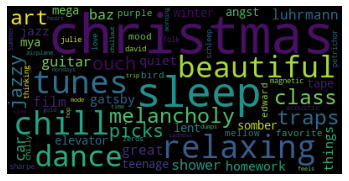

Cluster number  4


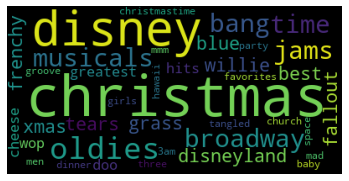

Cluster number  5


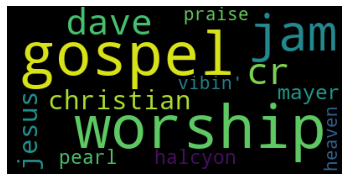

Cluster number  6


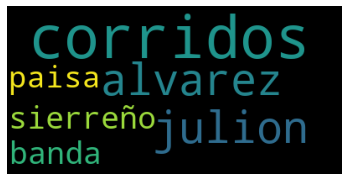

Cluster number  7


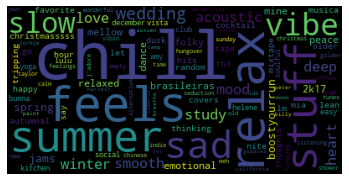

Cluster number  8


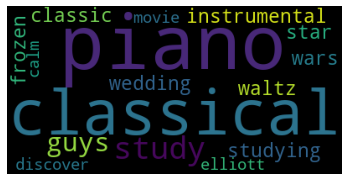

Cluster number  9


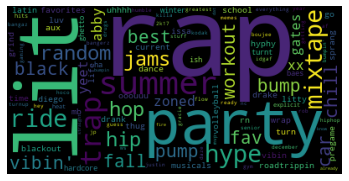

Cluster number  10


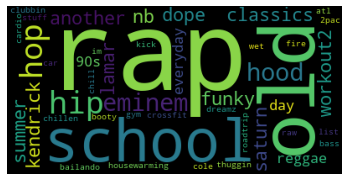

Cluster number  11


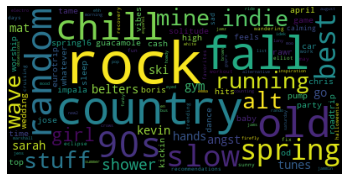

Cluster number  12


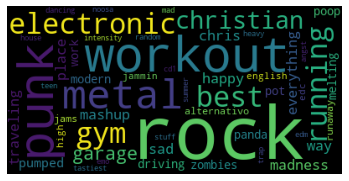

Cluster number  13


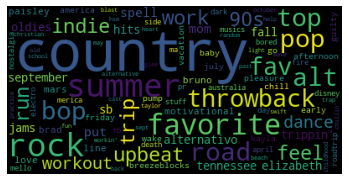

Cluster number  14


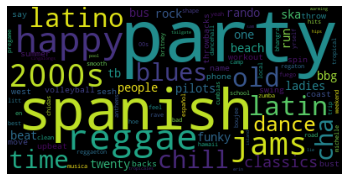

Cluster number  15


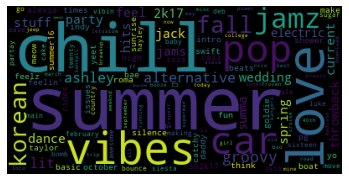

Cluster number  16


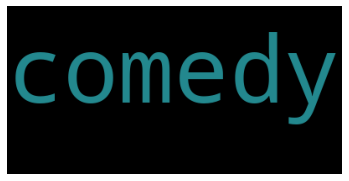

Cluster number  17


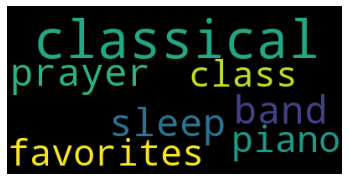

Cluster number  18


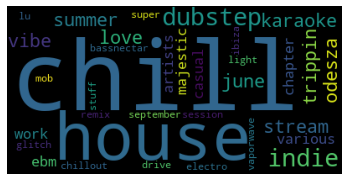

Cluster number  19


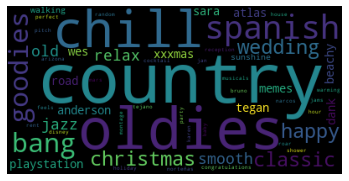

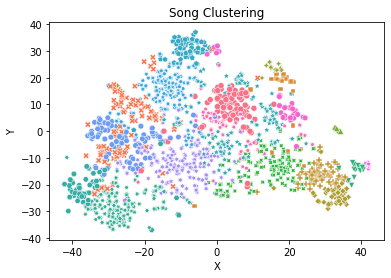

Playlist created


[('Toothbrush',),
 ('Mama',),
 ('Shed a Light',),
 ('I Like Me Better',),
 ("Don't Wanna Know (feat. Kendrick Lamar)",),
 ('New Rules',),
 ('Mi Gente',),
 ("Please Don't Go",),
 ('Scared to Be Lonely',),
 ('Let Me Love You',),
 ('Final Song',),
 ("We Don't Have To Take Our Clothes Off",),
 ('Roses',),
 ('Say It',),
 ('Closer',),
 ('Slide',),
 ('You & Me',)]

In [32]:
pipeline(True, training_data=training_data, test_data=test_data, feature_cols=feature_cols, X=X, Y=Y,  input_words=['chill', 'beach', 'party'], data=data, username="anikahamby")


In [33]:
def run_pipeline(input_words, username):
    words = input_words.split()
    if username == "":
        username=None
    return pipeline(False, input_words=words, username=username, demo=True)

In [35]:
demo = gr.Interface(fn=run_pipeline, inputs=["text", "text"], outputs="list")

In [34]:
demo.launch()

Rerunning server... use `close()` to stop if you need to change `launch()` parameters.
----
Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
